# 1. Introduction

This project aims to develop a set of predictive model for monitoring and optimizing water quality in freshwater aquaponics systems dedicated to catfish farming. By leveraging IoT sensor data and machine learning techniques, we analyze key environmental and biological factors influencing water health and fish well-being. Our system integrates real-time data collection from twelve aquaponics ponds, each monitored by an ESP-32 microcontroller equipped with sensors measuring parameters such as turbidity, temperature, ammonia, nitrate, dissolved oxygen, and pH.

The *Sensor Based Aquaponics Fish Pond Datasets*$\text{}^{1}$ consists of time-series records spanning from June to mid-October 2021, collected from twelve aquaponics ponds. Each pond is monitored individually, with IoT units capturing data every five minutes. These measurements provide insights into the complex interactions between water conditions and fish health, enabling predictive analytics for early issue detection and improved aquaponics management.

Key Variables in the Dataset:

- **Date/Time:** Timestamp of the recorded data.
- **Temperature:** Water temperature in degrees Celsius.
- **Turbidity:** Cloudiness or haziness of the water due to suspended particles.
- **Dissolved Oxygen (DO):** Oxygen available in water, essential for fish respiration and aerobic microbial processes.
- **pH:** Acidity or alkalinity of the water, crucial for maintaining optimal conditions.
- **Ammonia:** Concentration of ammonia, a byproduct of fish waste and organic matter decomposition.
- **Nitrate:** End-product of the nitrification process, impacting plant and microbial interactions.
- **Fish Population:** Number of fish in the pond at the time of measurement.
- **Fish Length:** Length of individual fish, indicating growth trends.
- **Fish Weight:** Mass of individual fish, reflecting health and development.

# 2. Library Imports and Functions
* Loads the dataset into a Pandas DataFrame.
* Displays the first few rows to understand the structure.
* Checks for missing values and basic statistics.

In [5]:
# import necessary libraries
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import DomainWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences
from keras import optimizers
import warnings
from sklearn.metrics import mean_squared_error as mse
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('future.no_silent_downcasting', True)
warnings.filterwarnings('ignore', category=FutureWarning, module='statsmodels.genmod.families.links')
warnings.filterwarnings("ignore", category=DomainWarning)

# 3. Data Loading and Initial Overview
In this section, we load the dataset and perform initial data exploration.

In [7]:
# load IoT dataset
pond1_raw = pd.read_csv('data/archive/IoTPond1.csv')
pond1_raw.head()

,created_at,entry_id,Temperature (C),Turbidity(NTU),Dissolved Oxygen(g/ml),PH,Ammonia(g/ml),Nitrate(g/ml),Population,Fish_Length(cm),Fish_Weight(g)
0,2021-06-19 00:00:05 CET,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
1,2021-06-19 00:01:02 CET,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2,2021-06-19 00:01:22 CET,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
3,2021-06-19 00:01:44 CET,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
4,2021-06-19 00:02:07 CET,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91


In [8]:
# get shape of data set, data types and non-null count
pond1_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83126 entries, 0 to 83125
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_at              83126 non-null  object 
 1   entry_id                83126 non-null  int64  
 2   Temperature (C)         83126 non-null  float64
 3   Turbidity(NTU)          83126 non-null  int64  
 4   Dissolved Oxygen(g/ml)  83126 non-null  float64
 5   PH                      83126 non-null  float64
 6   Ammonia(g/ml)           83074 non-null  float64
 7   Nitrate(g/ml)           83126 non-null  int64  
 8   Population              83126 non-null  int64  
 9   Fish_Length(cm)         83124 non-null  float64
 10  Fish_Weight(g)          83124 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 7.0+ MB


# 4. Data Cleaning
To prepare the dataset for analysis, we perform data cleaning and transformation steps, such as:  
- Handling missing values 
- Converting `datetime` for time-series analysis  
- Renaiming features for machine learning models  
These steps ensure the dataset is clean and suitable for predictive modeling.

In [10]:
# create a deep copy of the raw data
pond1 = pond1_raw.copy()

### Validate reading timestamp

In [12]:
# convert 'created_at' to datetime format
pond1['created_at'] = pd.to_datetime(pond1['created_at'], 
                                     errors='coerce') # if invalid date, replace with `NaT`
# check for invalid dates
print(f"Rows with invalid dates: { pond1['created_at'].isna().sum() }")

Rows with invalid dates: 0


### Modify columns names

In [14]:
# rename columns for easy reference
pond1.rename(columns={
    'created_at': 'datetime',
    'Temperature (C)': 'temperature',
    'Turbidity(NTU)': 'turbidity',
    'Dissolved Oxygen(g/ml)': 'dissolved_oxygen',
    'PH':'ph',
    'Ammonia(g/ml)': 'ammonia',
    'Nitrate(g/ml)': 'nitrate',
    'Population': 'population',
    'Fish_Length(cm)': 'fish_length',
    'Fish_Weight(g)': 'fish_weight'
}, inplace=True)

# set 'datetime' as the index for time-series analysis
pond1.set_index('datetime', inplace=True)

print(f"Renamed to columns: { pond1.columns.tolist() }")

Renamed to columns: ['entry_id', 'temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia', 'nitrate', 'population', 'fish_length', 'fish_weight']


### Check for missing data

In [16]:
# replace missing values with column-wise mean
pond1.fillna(pond1.mean(), inplace=True)
print("Missing values replaced by column-wise mean")
pond1.info()

Missing values replaced by column-wise mean
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83126 entries, 2021-06-19 00:00:05 to 2021-10-13 04:14:22
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   entry_id          83126 non-null  int64  
 1   temperature       83126 non-null  float64
 2   turbidity         83126 non-null  int64  
 3   dissolved_oxygen  83126 non-null  float64
 4   ph                83126 non-null  float64
 5   ammonia           83126 non-null  float64
 6   nitrate           83126 non-null  int64  
 7   population        83126 non-null  int64  
 8   fish_length       83126 non-null  float64
 9   fish_weight       83126 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 7.0 MB


### Cleaned dataset

In [18]:
pond1.head()

,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight
datetime,,,,,,,,,,
2021-06-19 00:00:05,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
2021-06-19 00:01:02,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2021-06-19 00:01:22,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
2021-06-19 00:01:44,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
2021-06-19 00:02:07,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91


# 5. Exploratory Data Analysis (EDA)
In this section, we analyze the data using visualizations and statistical analysis to uncover trends and relationships between variables. We then perform further data cleaning by handling outliers and resampling the data to fix timestamp gaps, ensuring a uniform datetime interval. Finally, we analyze the correlation between features to aid in the feature selection process.

### Summary statistics for numerical columns

In [21]:
pond1.describe()

,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight
count,83126.000000,83126.000000,83126.000000,83126.000000,83126.000000,8.312600e+04,83126.000000,83126.0,83126.000000,83126.000000
mean,84018.144516,24.573376,87.490160,12.390251,7.518329,2.030817e+08,458.294408,50.0,16.414686,44.568470
std,53579.484245,0.861532,25.859375,12.518253,0.534787,7.863770e+09,338.313206,0.0,5.272180,33.215091
min,1889.000000,-127.000000,1.000000,0.007000,-0.586270,6.770000e-03,45.000000,50.0,7.110000,2.910000
25%,24902.250000,24.125000,91.000000,3.440000,7.153520,4.584200e-01,146.000000,50.0,11.790000,14.190000
50%,103478.500000,24.562500,100.000000,7.133000,7.357790,6.139700e-01,347.000000,50.0,18.080000,54.700000
75%,131074.750000,24.937500,100.000000,15.819000,7.838980,1.565161e+01,823.000000,50.0,21.000000,67.520000
max,247405.000000,27.750000,100.000000,41.046000,8.551670,4.270000e+11,1936.000000,50.0,33.450000,318.640000


### Data Dristribution and Trends

#### Histrograms: Describes how values in the dataset are spread across a range.

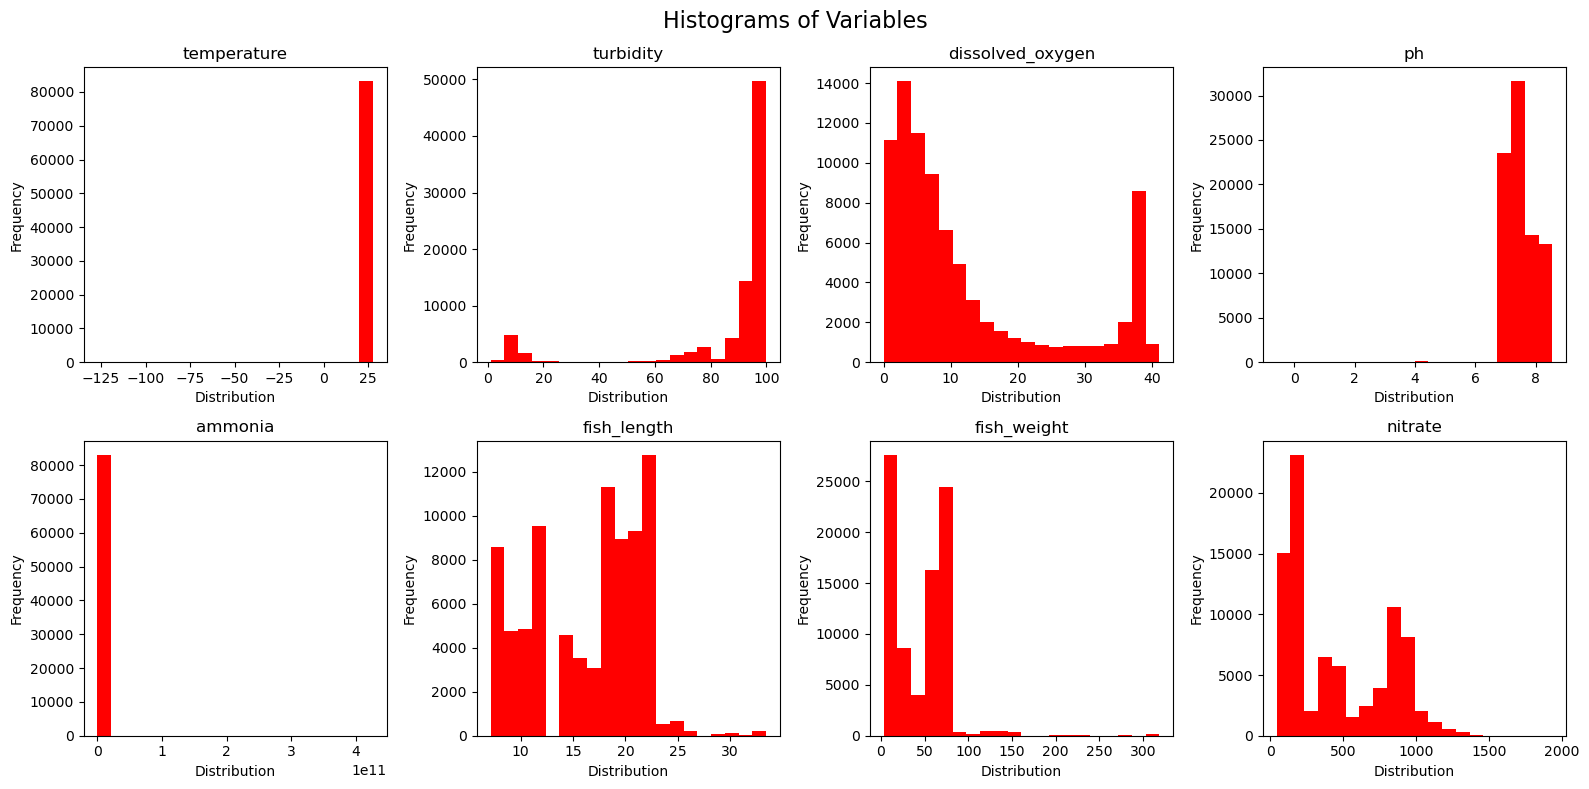

In [24]:
# without population since its a contant value
vars = ['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia', 'fish_length', 'fish_weight','nitrate']

# set grid and size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Histograms of Variables", fontsize=16)

# flatten axes for easy iteration
axes = axes.flatten()

# create each histogram
for i, col in enumerate(vars):
    axes[i].hist(pond1[col], bins=20, color='red')
    axes[i].set_title(col)
    axes[i].set_xlabel("Distribution")
    axes[i].set_ylabel("Frequency")

# adjusts spacing
plt.tight_layout()
plt.show()

#### Visual Representation: Shows patterns of change in the dataset over time.

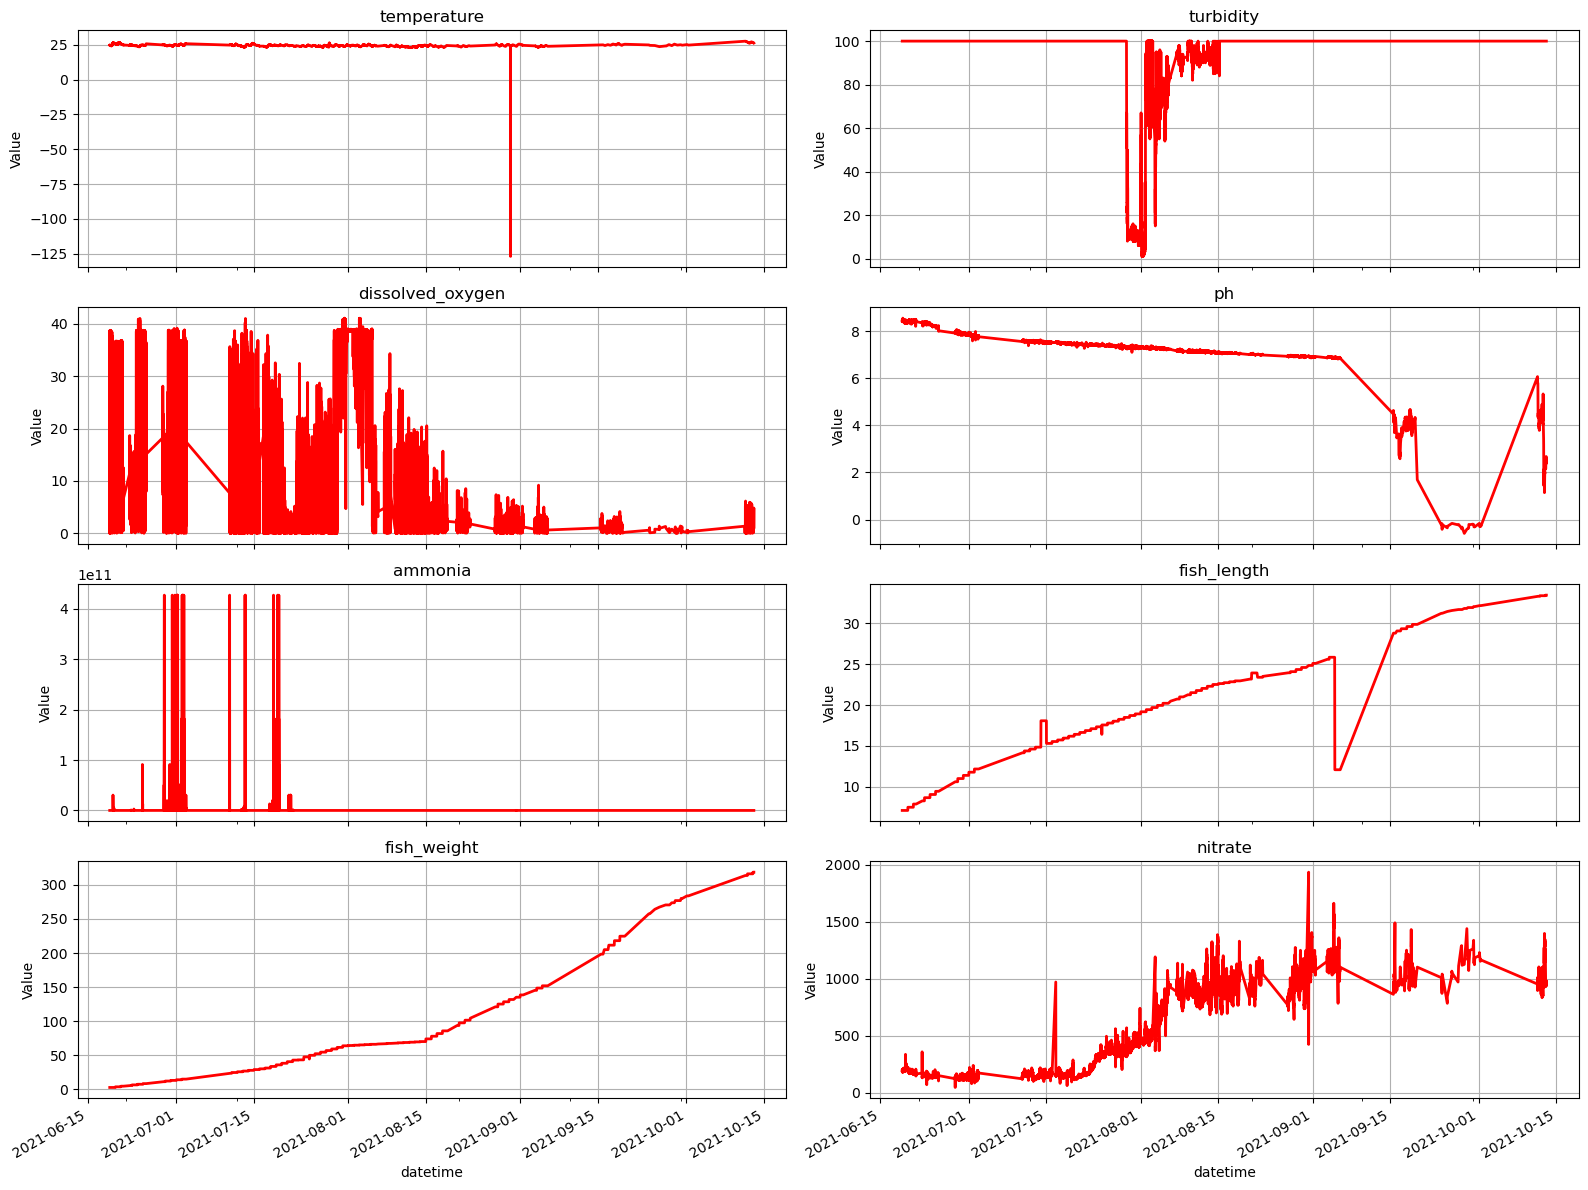

In [26]:
# set grid and size
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12), sharex=True)

# flatten axes for easy iteration
axes = axes.flatten()

# create subplots for each variables
for i, col in enumerate(vars):
    pond1[col].plot(ax=axes[i], title=col, linewidth=2, color='red')
    axes[i].set_ylabel("Value")
    axes[i].grid(True)  # add grid for better readability

# remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# adjusts spacing
plt.tight_layout()
plt.show()

### Handling outliers and timestamps gaps

#### Outliers: Replace outliers by interpolating between known values

In [29]:
# calculate quantiles
Q1 = pond1.quantile(0.25)
Q3 = pond1.quantile(0.75)
IQR = Q3 - Q1

# define the outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# filter the DataFrame to remove outliers
pond1_filtered = pond1[~((pond1 < lower_bound) | (pond1 > upper_bound)).any(axis=1)]

print("Outliers replaced by interpolating between known values.")

Outliers replaced by interpolating between known values.


#### Timestamp Gaps: Fix Missing Timestamps with 2 Minute Interval Interpolation

In [31]:
# get timedelta, the time difference between the first and last recorded reading
td = pond1_filtered['entry_id'].idxmax()-pond1_filtered['entry_id'].idxmin()

# convert into seconds
total_seconds = td.total_seconds()

# calculate the number of 20-second intervals
intervals = total_seconds // 20  # floor division to get whole intervals
print(f"Total 20-second intervals: {int(intervals)}")

# generate a full range of 20-second intervals
full_range = pd.date_range(start=pond1_filtered.index.min(), end=pond1_filtered.index.max(), freq='20S')

# reindex the DataFrame to fill missing timestamps
pond1_filled = pond1_filtered.reindex(full_range).interpolate()

# define time-based sampling parameters
timeStep = 20 ## 20 seconds
freqPerMinute = 3
valuesPerDay = freqPerMinute*60*24 # total expected readings per day
print("Values to be collected per day",valuesPerDay)
print("Total Values Expected", intervals)
print("Actual Values", pond1_filtered.shape[0])
print("Interpolated",pond1_filled.shape[0])

pond1_filled.resample('5T').mean() # convert data from 20-second intervals to 5-minute averages
pond1_2_min = pond1_filled.resample('2T').mean() # Resampling to 2-minute intervals

Total 20-second intervals: 332619
Values to be collected per day 4320
Total Values Expected 332619.0
Actual Values 49144
Interpolated 332620


### Resampled dataset

In [33]:
pond1_filtered=pond1_2_min
pond1_filtered.head()

,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight
2021-06-19 00:00:00,1891.391304,24.873641,100.0,4.649967,8.433601,0.45842,192.989130,50.0,7.11,2.91
2021-06-19 00:02:00,1897.130435,24.870380,100.0,4.997889,8.433482,0.45842,192.963043,50.0,7.11,2.91
2021-06-19 00:04:00,1902.869565,24.867120,100.0,5.345811,8.433364,0.45842,192.936957,50.0,7.11,2.91
2021-06-19 00:06:00,1908.608696,24.863859,100.0,5.693733,8.433245,0.45842,192.910870,50.0,7.11,2.91
2021-06-19 00:08:00,1914.347826,24.860598,100.0,6.041654,8.433127,0.45842,192.884783,50.0,7.11,2.91


#### Histrograms: post-cleaning and resampling

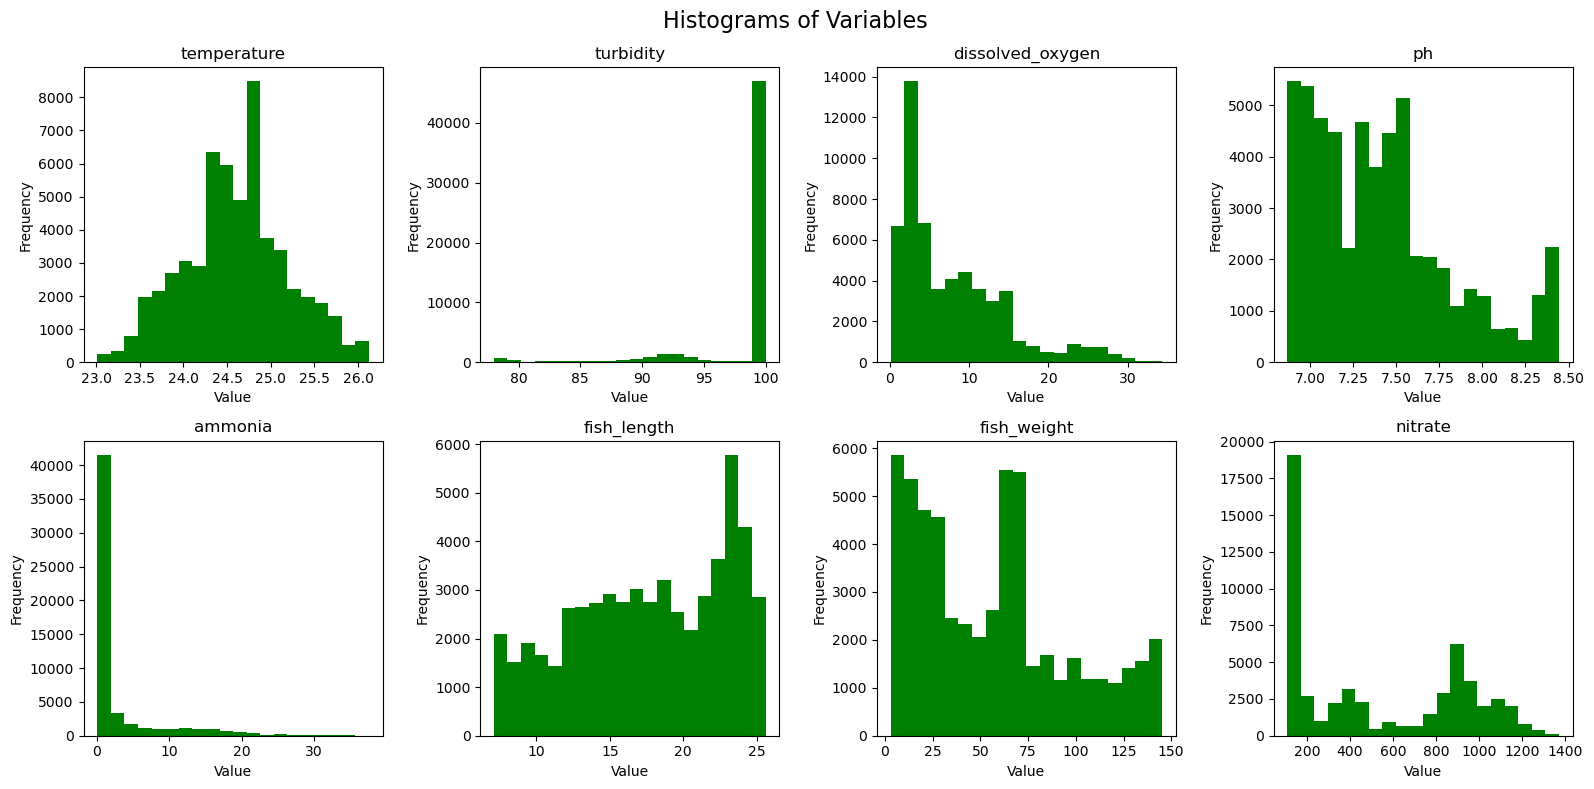

In [35]:
# set grid and size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Histograms of Variables", fontsize=16)

# flatten axes for easy iteration
axes = axes.flatten()

# create each histogram
for i, col in enumerate(vars):
    axes[i].hist(pond1_filtered[col], bins=20,  color='green')
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# adjusts spacing
plt.tight_layout()
plt.show()

#### Visual Representation: post-cleaning and resampling

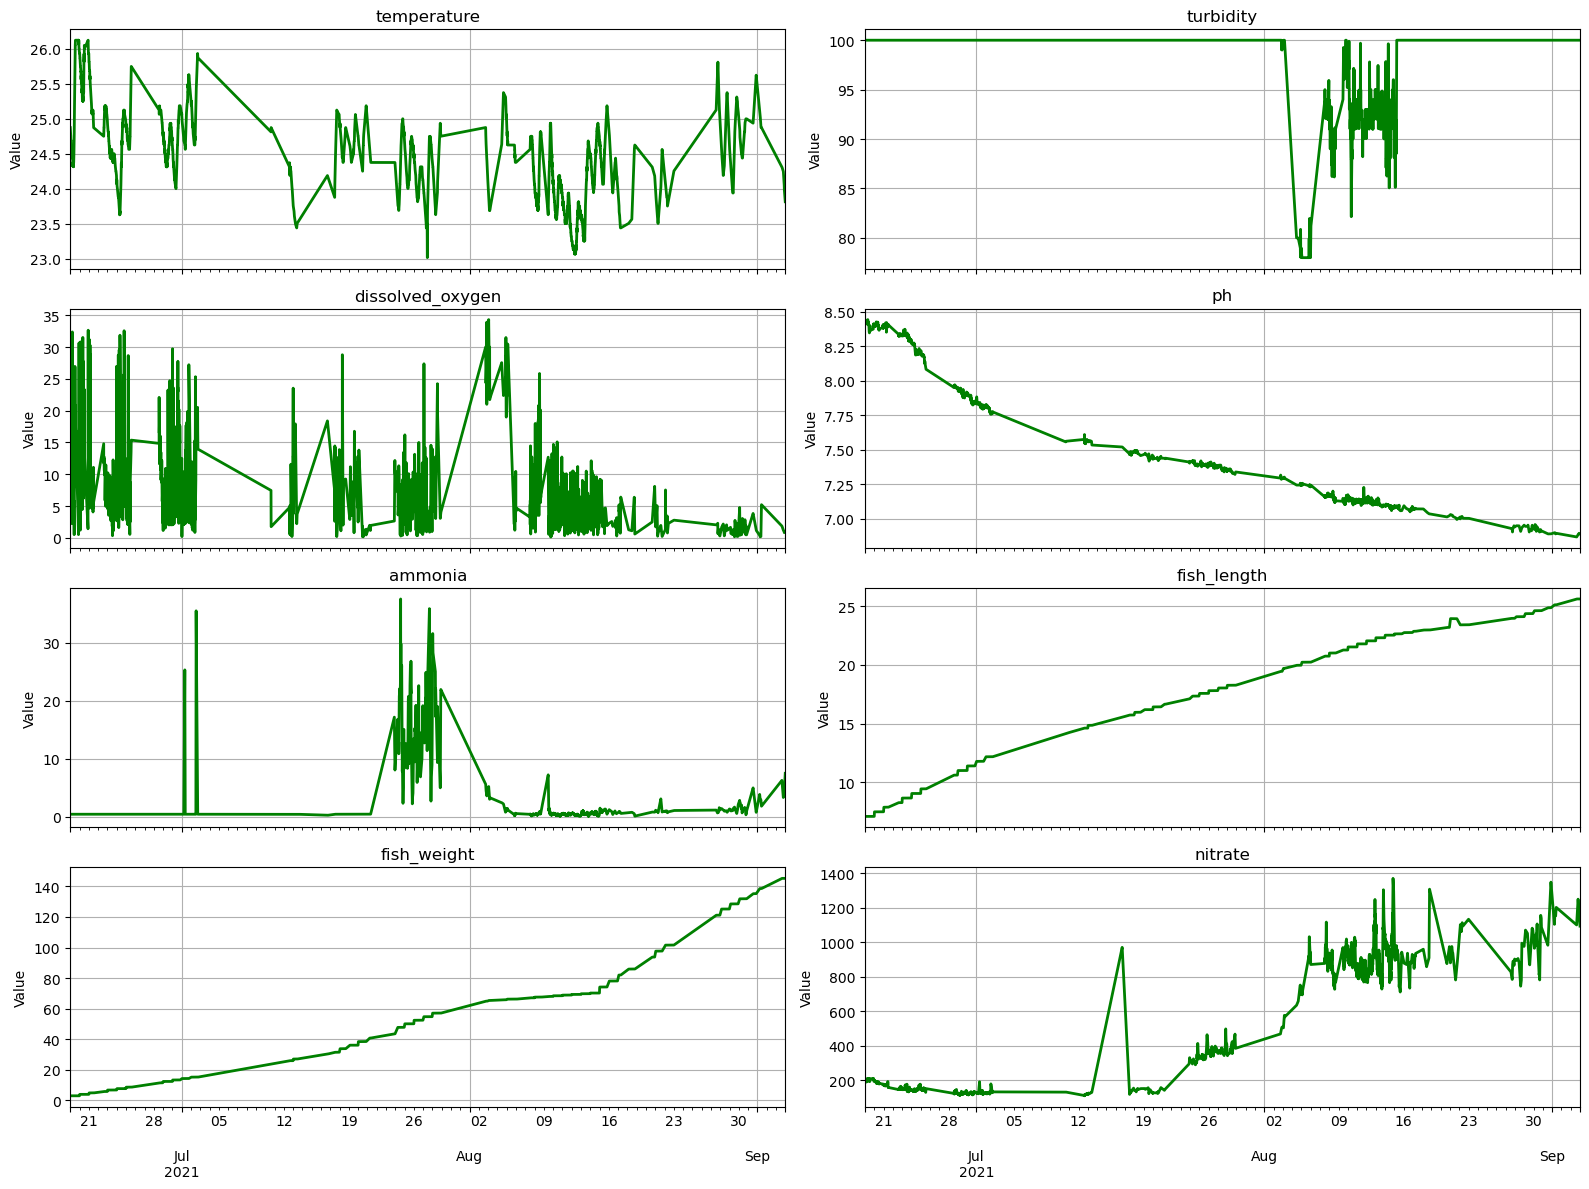

In [37]:
# set grid and size
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12), sharex=True)

# flatten axes for easy iteration
axes = axes.flatten()

# create subplots for each variables
for i, col in enumerate(vars):
    pond1_filtered[col].plot(ax=axes[i], title=col, linewidth=2, color='green')
    axes[i].set_ylabel("Value")
    axes[i].grid(True)  # add grid for better readability

# remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# adjusts spacing
plt.tight_layout()
plt.show()

### Data Correlation

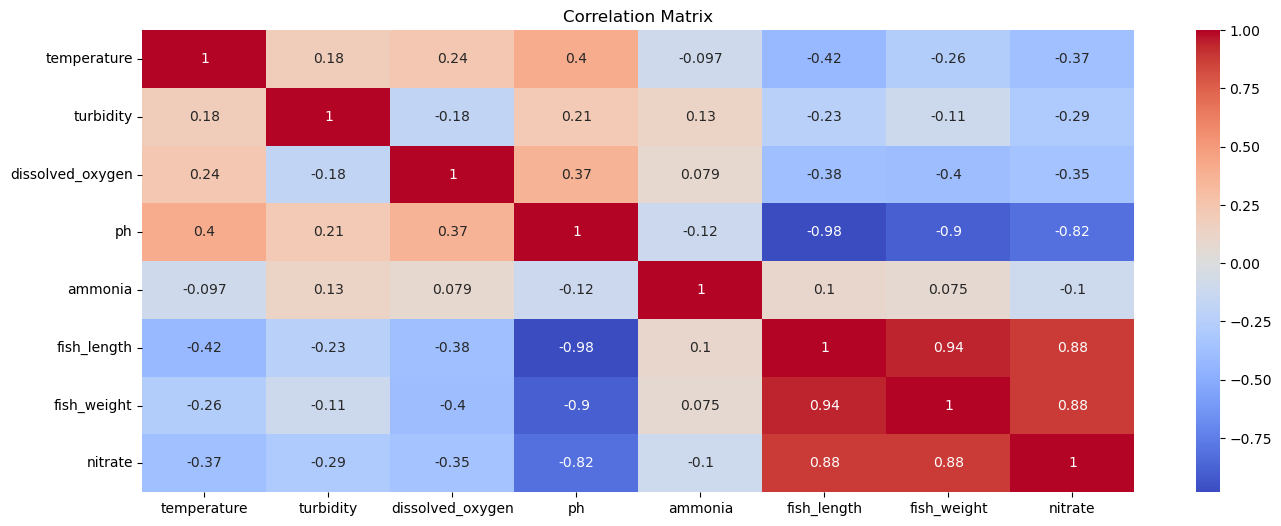

In [39]:
# compute correlation matrix
corr_matrix = pond1_filtered[vars].corr()

# display heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# 6. Machine Learning Models  
In this section, we implement and evaluate a **(6.2)** traditional Machine Learning (ML) model and a **(6.3)** deep learning ML model to predict nitrate and pH levels in the pond, respectively. Each model makes predictions based on time-series parameters to provide a prediction window of 5 time steps.  

### Steps:  
- **Data Preparation:** Identifying target variables and converting timestamps into Unix timestamps.  
- **Data Splitting:** Dividing the data into training (80%) and testing (20%) sets.  
- **Model Training:** Implementing both traditional ML (**Linear Regression**) and deep learning (**LSTM**).  
  - **Linear Regression** was used to predict nitrate levels.  
  - **LSTM** was used to predict pH levels.  
- **Performance Evaluation:** Both models were tested against the test dataset, comparing results using **MSE, RMSE, and R-square scores**.  


## 6.1. Data Preparation

#### Target Variables

In [43]:
predicted_feature_ml = 'nitrate' # target variable for traditional ML
predicted_feature_dp = 'ph' # target variavle for deep learning ML

#### Convert the index (datetime) into Unix timestamps

In [45]:
pond1_filtered['unix'] = pd.to_datetime(pond1_filtered.index).astype('int64')/1e9  # divide by 1e9 to convert from nanoseconds to seconds

## 6.2. Traditional ML: Lineal Regression - Predicting Nitrate Levels

Prediction of Nitrate at 10th minute(5 th Time Step) from the Nitrate sensor reading

#### Train-Test Split

In [49]:
train_size = int(len(pond1_filtered[predicted_feature_ml]) * 0.8) # 80% slice
train_ml, test_ml = pond1_filtered[['unix',predicted_feature_ml]].iloc[:train_size], pond1_filtered[['unix',predicted_feature_ml]].iloc[train_size:]

print(f"Train Size: {len(train_ml)}, Test Size: {len(test_ml)}")

Train Size: 44349, Test Size: 11088


#### Prepare training data sequence with a predictive horizon

In [51]:
n_s = 5000  # number of samples to use for training (for speed)
future_steps = 5  # number of future predictions

# extract the last `n_s` samples
ts = pd.DataFrame(train_ml['unix'].iloc[-n_s:].values)  # extract last `n_s` timestamps
ys = pd.DataFrame(train_ml[predicted_feature_ml].iloc[-n_s:].values)  # extract last `n_s` target values

ph = 5 # since time step is 2 mins, 5 steps required to predict 10th min
ph_index = 5
mu = 0.9

#### Model Training

In [53]:
# This function trains a weighted linear regression model using past time-series data 
# and generates predictions for future time steps.  
def train_and_predict(ts, ys, mu, future_steps):
    tp_pred = np.zeros(n_s + future_steps) 
    yp_pred = np.zeros(n_s + future_steps)

    for i in range(2, n_s + 1):  # train on the last `n_s` points
        ts_tmp = ts[:i]
        ys_tmp = ys[:i]
        ns = len(ys_tmp)

        # weighting system for time relevance
        weights = np.ones(ns) * mu
        for k in range(ns):
            weights[k] = weights[k] ** k
        weights = np.flip(weights, 0)

        # train weighted linear regression model
        lm_tmp = LinearRegression()
        model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

        # prevent index out of bounds
        if ns + ph_index - 1 < len(ts):
            tp = ts.iloc[ns + ph_index - 1, 0]  # select timestamp
        else:
            tp = ts.iloc[-1, 0] + (ph_index * (ts.iloc[1, 0] - ts.iloc[0, 0]))  # extrapolate future timestamp

        yp = model_tmp.predict([[tp]])  # make prediction
        tp_pred[i - 2] = tp
        yp_pred[i - 2] = yp[0, 0]

    # predict future values beyond dataset
    last_timestamp = ts.iloc[-1, 0]  # last timestamp in dataset
    time_step = ts.iloc[1, 0] - ts.iloc[0, 0]  # time interval between points

    for j in range(future_steps):
        tp_future = last_timestamp + (j + 1) * time_step  # future timestamp
        yp_future = model_tmp.predict([[tp_future]])  # predict next value
        tp_pred[n_s + j] = tp_future
        yp_pred[n_s + j] = yp_future[0, 0]

    return tp_pred, yp_pred

In [54]:
# This function visualizes the actual vs. predicted values from the trained model  
# to assess its performance over a selected time window.  
def plotData(ys,yp_pred,mu,first,window=1000,title="Prediction"):
    # plot first 200 data points/predictions
    fig, ax = plt.subplots(figsize=(12,6))
    fig.suptitle(title, fontsize=22, fontweight='bold')
    ax.set_title('mu = %g' %(mu))
    if first== True:
        ax.plot(train_ml.index.values[ph_index:window+ph_index], yp_pred[0:window], label=f'Predicted {predicted_feature_ml}') 
        ax.plot(train_ml.index.values[ph_index:window+ph_index], ys.iloc[ph_index:window+ph_index,0], label=f'Actual {predicted_feature_ml}') 
    else:
        ax.plot(train_ml.index.values[n_s-window+ph_index:n_s+ph_index], yp_pred[-window:], label=f'Predicted {predicted_feature_ml}') 
        ax.plot(train_ml.index.values[n_s-window+ph_index:n_s+ph_index], ys.iloc[n_s-window+ph_index:n_s+ph_index,0], label=f'Actual {predicted_feature_ml}') 
    ax.set_xlabel('time (CET)')
    ax.set_ylabel(f'{predicted_feature_ml}(unit)')
    ax.legend()
    plt.show()

In [55]:
# train and predict
tp_pred, yp_pred = train_and_predict(ts, ys, mu=0.9, future_steps=future_steps) 

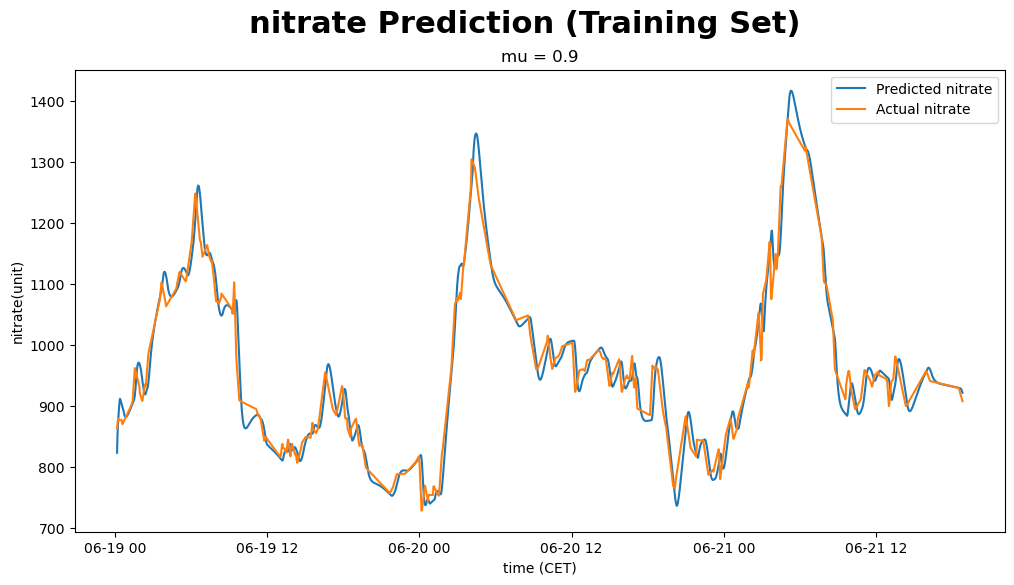

In [56]:
# plot results
plotData(ys,yp_pred,mu=0.9,first=True,window=2000, title=f"{predicted_feature_ml} Prediction (Training Set)") 

#### Model Validation

In [58]:
n_s = 5000  # number of samples to use for training
future_steps = 5  # number of future predictions

# extract the last `n_s` samples
ts = pd.DataFrame(test_ml['unix'].iloc[-n_s:].values)  # Extract last `n_s` timestamps
ys = pd.DataFrame(test_ml[predicted_feature_ml].iloc[-n_s:].values)  # Extract last `n_s` target values

ph = 5 # Since time step is 2 mins, 5 steps required to predict 10th min
ph_index = 5
mu = 0.9

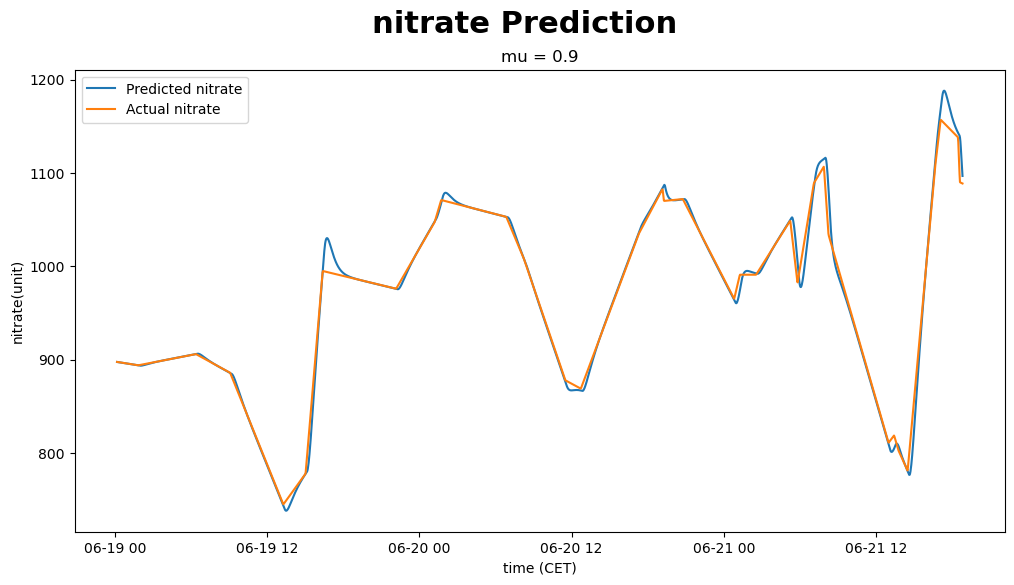

In [59]:
# train and predict with unseen data
tp_pred,yp_pred=train_and_predict(ts,ys,mu=0.9, future_steps=future_steps)
plotData(ys,yp_pred,mu=0.9,first=True,window=2000, title=f"{predicted_feature_ml} Prediction") # plot results

nitrate_y = yp_pred # save for later export data.

In [60]:
ys = np.array(ys[:5000])  # convert to NumPy array if not already
yp_pred = np.array(yp_pred[:5000])

# compute MSE
mean_squared_error_lm = mean_squared_error(ys, yp_pred)

print(f"Linear Regression MSE : {np.round(mean_squared_error_lm, decimals=4)}")

Linear Regression MSE : 278.038


## 6.3 Deep Learning: LSTM (pH)

#### Train-Test Split

In [63]:
# train/test splits
train_size = int(len(pond1_filtered[predicted_feature_dp]) * 0.8)
train_dp, test_dp = pond1_filtered[['unix',predicted_feature_dp]].iloc[:train_size], pond1_filtered[['unix',predicted_feature_dp]].iloc[train_size:]

print(f"Train Size: {len(train_dp)}, Test Size: {len(test_dp)}")

Train Size: 44349, Test Size: 11088


#### Prepare training data sequence with a predictive horizon

In [65]:
# prepares time-series data for training an LSTM model  
# by converting it into sequences of fixed length (`seq_length = 30`)

seq_length = 30 # number of past time steps used as input
ph = 5 # prediction horizon (steps ahead to forecast)

feat_cols = [predicted_feature_dp] # feature for input sequence
seq_arrays=[] # input sequence
seq_labs=[] # labels
train_df_as_array=train_dp[predicted_feature_dp].values

# generate sequences for training the LSTM model
for i in range(train_dp.shape[0]-seq_length-ph):
    seq=[[j] for j in train_df_as_array[i:i+seq_length]]
    seq_arrays.append(seq)
    pred_val=train_df_as_array[i+seq_length+ph-1]
    seq_labs.append(pred_val)
    
#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

#### Model Training

In [67]:
# build the network
nb_features = 1 
nb_out = 1
model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=20, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=10,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
optimizer = optimizers.Adam(learning_rate = 0.0005)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays,seq_labs, epochs=200, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=60, verbose=0, mode='min')]
          )

# list all data in history
print(history.history.keys())

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 20)         │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,011 (11.76 KB)

 Trainable params: 3,011 (11.76 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
85/85 - 3s - 30ms/step - loss: 45.2889 - mse: 45.2889 - val_loss: 26.1972 - val_mse: 26.1972
Epoch 2/200
85/85 - 2s - 19ms/step - loss: 24.1481 - mse: 24.1481 - val_loss: 13.5801 - val_mse: 13.5801
Epoch 3/200
85/85 - 2s - 19ms/step - loss: 15.1156 - mse: 15.1156 - val_loss: 8.5451 - val_mse: 8.5451
Epoch 4/200
85/85 - 2s - 21ms/step - loss: 10.7167 - mse: 10.7167 - val_loss: 5.4306 - val_mse: 5.4306
Epoch 5/200
85/85 - 2s - 19ms/step - loss: 7.4733 - mse: 7.4733 - val_loss: 3.2674 - val_mse: 3.2674
Epoch 6/200
85/85 - 2s - 19ms/step - loss: 5.4786 - mse: 5.4786 - val_loss: 2.0288 - val_mse: 2.0288
Epoch 7/200
85/85 - 2s - 19ms/step - loss: 4.1669 - mse: 4.1669 - val_loss: 1.2215 - val_mse: 1.2215
Epoch 8/200
85/85 - 2s - 19ms/step - loss: 3.3183 - mse: 3.3183 - val_loss: 0.6929 - val_mse: 0.6929
Epoch 9/200
85/85 - 2s - 19ms/step - loss: 2.6772 - mse: 2.6772 - val_loss: 0.3599 - val_mse: 0.3599
Epoch 10/200
85/85 - 2s - 20ms/step - loss: 2.2616 - mse: 2.2616 - val_los

In [68]:
# evaluate model and print results
y_pred = model.predict(seq_arrays)

# compute metrics
mse = mean_squared_error(y_pred, seq_labs)
rmse = np.sqrt(mse)

print("\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

1385/1385 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Model Performance:
MSE: 0.0014
RMSE: 0.0373


1385/1385 - 1s - 1ms/step - loss: 0.0014 - mse: 0.0014

MSE: 0.00139157276134938
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


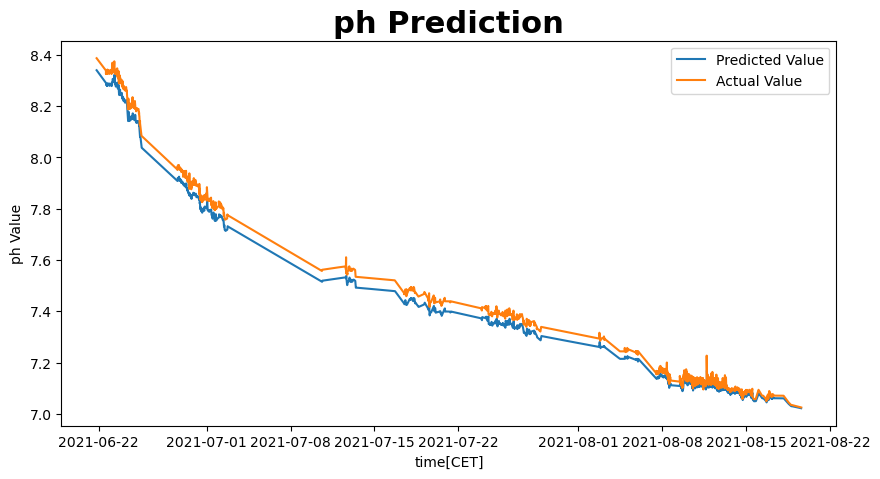

In [69]:
scores_test = model.evaluate(seq_arrays,seq_labs, verbose=2) # get scores for evaluation
print('\nMSE: {}'.format(scores_test[1]))

# generate predictions on the entire dataset
y_pred_test = model.predict(seq_arrays) # model predictions
y_true_test = seq_labs # actual values

# plot the predicted data vs. the actual data
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(train_dp[seq_length+ph+2000:].index.values,y_pred_test[2000:], label = 'Predicted Value')
plt.plot(train_dp[seq_length+ph+2000:].index.values,y_true_test[2000:], label = 'Actual Value')
plt.title(f'{predicted_feature_dp} Prediction', fontsize=22, fontweight='bold')
plt.ylabel(f'{predicted_feature_dp} Value')
plt.xlabel('time[CET]')
plt.legend()
plt.show()

#### Model Validation

In [71]:
# empty lists to store validation input sequences and labels
val_arrays = []
val_labs = []

ph = 5 # prediction horizo

feat_cols = [predicted_feature_dp] # feature

val_df_as_array = test_dp[predicted_feature_dp].values # convert validation data into a numpy array for easier slicing

# generate sequences for validation
for i in range(test_dp.shape[0] - seq_length - ph): 
    seq = [[j] for j in val_df_as_array[i:i + seq_length]]  # extract a sequence of length `seq_length`
    val_arrays.append(seq) 

    # extract the corresponding target value (5 steps ahead)
    pred_val = val_df_as_array[i + seq_length + ph - 1]
    val_labs.append(pred_val)  # append target value to labels list

# convert input sequences to numpy arrays and cast to float32 for keras/tensorflow compatibility
val_arrays = np.array(val_arrays, dtype=object).astype(np.float32)

# convert labels to numpy arrays and cast to float32 for keras/tensorflow compatibility
val_labs = np.array(val_labs, dtype=object).astype(np.float32)

In [72]:
# evaluate model and print results
y_pred = model.predict(val_arrays)

# compute metrics
mse = mean_squared_error(y_pred, val_labs)
rmse = np.sqrt(mse)

print("\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Model Performance:
MSE: 0.0002
RMSE: 0.0147


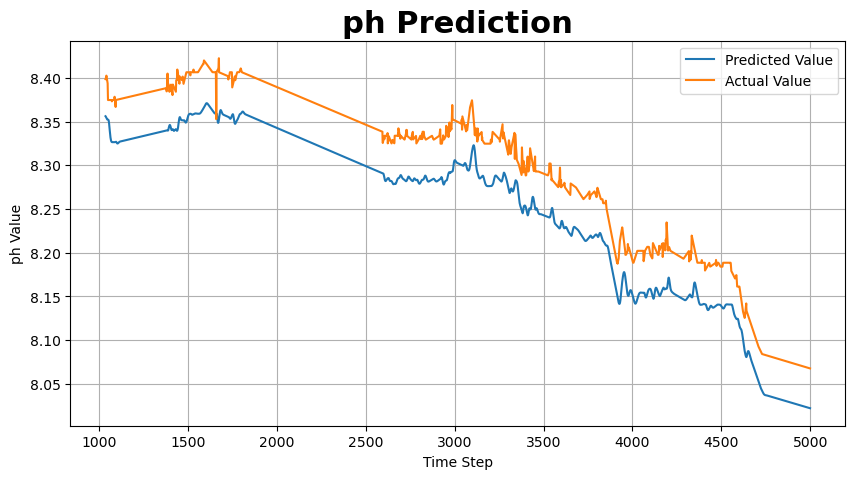

In [73]:
# convert NumPy array `ys` into a DataFrame with an index
ys_df = pd.DataFrame(ys, columns=[predicted_feature_dp])
ys_df['index'] = range(len(ys))  # Create a numeric index if necessary
ys_df.set_index('index', inplace=True)  # Set index for proper slicing

# ensure y-values are 1D arrays
y_pred_test = y_pred_test.flatten()
y_true_test = y_true_test.flatten()

window = 1000  # define the window size

# ensure both x (index) and y (values) match in length
min_length = min(len(ys_df.iloc[seq_length+ph+window:].index), len(y_pred_test[window:]))

# slice the DataFrame correctly
x_values = ys_df.iloc[seq_length+ph+window:].index[:min_length]
y_pred_values = y_pred_test[window:window+min_length]
y_true_values = y_true_test[window:window+min_length]

# plot 
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(x_values, y_pred_values, label='Predicted Value')
plt.plot(x_values, y_true_values, label='Actual Value')
plt.title(f'{predicted_feature_dp} Prediction', fontsize=22, fontweight='bold')
plt.ylabel(f'{predicted_feature_dp} Value')
plt.xlabel('Time Step')
plt.legend()
plt.grid(True)
plt.show()

# 7. Model Deployment  

In this section, we deploy the trained and tested models to generate 5-step predictions for nitrate and pH levels in the pond. These predictions will be used to establish a real-time dashboard for visualizing water quality insights obtained through this notebook. Here we bridge machine learning modeling with real-time decision-making, ensuring that the insights gained can be effectively utilized for aquaponics system optimization.  

### Linear Regression Predictions

In [76]:
pond1_predictions = pond1_filtered.copy() # copy the original dataset to preserve data
pond1_predictions['nitrate_prediction'] = np.nan # new empty column for predictions

# check that 'datetime' is the index
if not isinstance(pond1_predictions.index, pd.DatetimeIndex): # if not, make it the index
    pond1_predictions = pond1_predictions.set_index('datetime')

last_datetime = pond1_predictions.index[-1] #  last timestamp from the existing dataset

future_dates = [last_datetime + pd.Timedelta(minutes=2 * (i + 1)) for i in range(5)] # incrementing by 2 minutes

# append the new empty rows to the original dataset
future_df = pd.DataFrame(index=future_dates, columns=pond1_predictions.columns)
pond1_predictions = pd.concat([pond1_predictions, future_df])

nitrate_predictions = nitrate_y[nitrate_y.size-5:] # predictions

last_5_indices = pond1_predictions.index[-5:]  # Select last 5 row indices

pond1_predictions.loc[last_5_indices, 'nitrate_prediction'] = nitrate_predictions # add predictions to the nitrate column 

### LSTM Predictions

In [78]:
pond1_predictions['ph_predictions'] = np.nan

future_steps = 5  # number of future steps to predict

last_sequence = pond1_filtered[predicted_feature_dp].iloc[-seq_length:].values.reshape(1, seq_length, 1) #  the last known sequence

ph_predictions = [] # to store predictions

# generate predictions iteratively for the next 5 time steps
for _ in range(future_steps):
    next_pred = model.predict(last_sequence).flatten()[0]  
    ph_predictions.append(next_pred)

    last_sequence = np.roll(last_sequence, shift=-1, axis=0)
    last_sequence[-1, 0] = next_pred  # replace last time step with predicted value

ph_predictions = np.array(ph_predictions) # convert to NumPy array for easy handling

print("Next 5 Predicted PH Values:", ph_predictions)

# assign predictions to the nitrate column in those last 5 rows
pond1_predictions.loc[last_5_indices, 'ph_predictions'] = ph_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Next 5 Predicted PH Values: [6.9131885 6.9131894 6.9131894 6.9131894 6.9131894]


### Final dataset with predictions

In [80]:
pond1_predictions.tail(7)

,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight,unix,nitrate_prediction,ph_predictions
2021-09-03 23:50:00,166902.0,23.8125,100.0,0.874,6.89023,7.51259,1094.0,50.0,25.6,145.3,1.630713e+09,NaN,NaN
2021-09-03 23:52:00,166902.0,23.8125,100.0,0.874,6.89023,7.51259,1094.0,50.0,25.6,145.3,1.630713e+09,NaN,NaN
2021-09-03 23:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1091.066639,6.913188
2021-09-03 23:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1090.098469,6.913189
2021-09-03 23:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1089.130299,6.913189
2021-09-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1088.162129,6.913189
2021-09-04 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1087.193959,6.913189


### Export Data for Tableau

In [82]:
# convert the index (datetime) back to a column and rename it to 'datetime'
pond1_predictions = pond1_predictions.reset_index().rename(columns={'index': 'datetime'})
pond1_predictions.to_csv("pond1_predictions.csv", index=False)
print("Data saved as CSV: pond1_predictions.csv") # save data with predictions to establish a real-time dashboard in Tableau

Data saved as CSV: pond1_predictions.csv



----------------
$^{1}$ Ogbuokiri, B. (2021). Sensor-based aquaponics fish pond datasets. Kaggle. https://www.kaggle.com/datasets/ogbuokiriblessing/sensor-based-aquaponics-fish-pond-datasets